In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from datasets import load_dataset
from torchvision.transforms import functional as F
import torchmetrics
from PIL import Image

In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load dataset
print("Loading Cityscapes dataset...")
ds = load_dataset("Chris1/cityscapes")
print(ds)

Loading Cityscapes dataset...


dataset_infos.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

train-00000-of-00014.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

train-00001-of-00014.parquet:   0%|          | 0.00/521M [00:00<?, ?B/s]

train-00002-of-00014.parquet:   0%|          | 0.00/503M [00:00<?, ?B/s]

train-00003-of-00014.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

train-00004-of-00014.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00005-of-00014.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

train-00006-of-00014.parquet:   0%|          | 0.00/529M [00:00<?, ?B/s]

train-00007-of-00014.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00008-of-00014.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

train-00009-of-00014.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

train-00010-of-00014.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

train-00011-of-00014.parquet:   0%|          | 0.00/515M [00:00<?, ?B/s]

train-00012-of-00014.parquet:   0%|          | 0.00/517M [00:00<?, ?B/s]

train-00013-of-00014.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/400M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

test-00000-of-00007.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

test-00001-of-00007.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

test-00002-of-00007.parquet:   0%|          | 0.00/503M [00:00<?, ?B/s]

test-00003-of-00007.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

test-00004-of-00007.parquet:   0%|          | 0.00/501M [00:00<?, ?B/s]

test-00005-of-00007.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

test-00006-of-00007.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2975 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1525 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'semantic_segmentation'],
        num_rows: 2975
    })
    validation: Dataset({
        features: ['image', 'semantic_segmentation'],
        num_rows: 500
    })
    test: Dataset({
        features: ['image', 'semantic_segmentation'],
        num_rows: 1525
    })
})


In [5]:
# These are the class names and their corresponding label values
CITYSCAPES_CLASSES = {
    0: 'unlabeled',
    1: 'ego vehicle',
    2: 'rectification border',
    3: 'out of roi',
    4: 'static',
    5: 'dynamic',
    6: 'ground',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'caravan',
    30: 'trailer',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle'
}

NUM_CLASSES = len(CITYSCAPES_CLASSES)

# Define color map for visualization
COLORMAP = [
    [0, 0, 0],        # unlabeled
    [0, 0, 0],        # ego vehicle
    [0, 0, 0],        # rectification border
    [0, 0, 0],        # out of roi
    [0, 0, 0],        # static
    [111, 74, 0],     # dynamic
    [81, 0, 81],      # ground
    [128, 64, 128],   # road
    [244, 35, 232],   # sidewalk
    [250, 170, 160],  # parking
    [230, 150, 140],  # rail track
    [70, 70, 70],     # building
    [102, 102, 156],  # wall
    [190, 153, 153],  # fence
    [180, 165, 180],  # guard rail
    [150, 100, 100],  # bridge
    [150, 120, 90],   # tunnel
    [153, 153, 153],  # pole
    [153, 153, 153],  # polegroup
    [250, 170, 30],   # traffic light
    [220, 220, 0],    # traffic sign
    [107, 142, 35],   # vegetation
    [152, 251, 152],  # terrain
    [70, 130, 180],   # sky
    [220, 20, 60],    # person
    [255, 0, 0],      # rider
    [0, 0, 142],      # car
    [0, 0, 70],       # truck
    [0, 60, 100],     # bus
    [0, 0, 90],       # caravan
    [0, 0, 110],      # trailer
    [0, 80, 100],     # train
    [0, 0, 230],      # motorcycle
    [119, 11, 32]     # bicycle
]

COLORMAP = np.array(COLORMAP) / 255.0

In [ ]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            split (string): 'train', 'val', or 'test'
            transform (callable, optional): Optional transform to be applied on the images.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        
        # Paths for different data types
        self.images_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.stylized_dir = os.path.join(root_dir, 'stylized', split)  # Assuming you have stylized images
        self.labels_dir = os.path.join(root_dir, 'gtFine', split)
        
        # Get file names
        self.images = []
        for city in os.listdir(self.images_dir):
            city_path = os.path.join(self.images_dir, city)
            for img_name in os.listdir(city_path):
                if img_name.endswith('_leftImg8bit.png'):
                    self.images.append((city, img_name))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        city, img_name = self.images[idx]
        
        # Get image paths
        img_path = os.path.join(self.images_dir, city, img_name)
        
        # For stylized image, ensure the name format matches
        # (You might need to adjust this based on your stylized image naming convention)
        stylized_img_name = img_name.replace('_leftImg8bit.png', '_stylized.png')
        stylized_path = os.path.join(self.stylized_dir, city, stylized_img_name)
        
        # For label, convert image name to label name format
        label_name = img_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
        label_path = os.path.join(self.labels_dir, city, label_name)
        
        # Load images and label
        image = Image.open(img_path).convert('RGB')
        stylized = Image.open(stylized_path).convert('RGB')
        label = Image.open(label_path)
        
        # Apply transforms if specified
        if self.transform:
            image, stylized, label = self.transform(image, stylized, label)
        else:
            # Default transforms
            image = transforms.ToTensor()(image)
            stylized = transforms.ToTensor()(stylized)
            label = torch.from_numpy(np.array(label, dtype=np.int64))
        
        return image, stylized, label

In [7]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create datasets
train_dataset = CityscapesDataset(ds['train'], transform=transform_train, is_train=True)
val_dataset = CityscapesDataset(ds['validation'], transform=transform_val, is_train=False)
test_dataset = CityscapesDataset(ds['test'], transform=transform_val, is_train=False)

In [9]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [25]:
# Print dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 2975
Validation samples: 500
Testing samples: 1525


Displaying training samples...


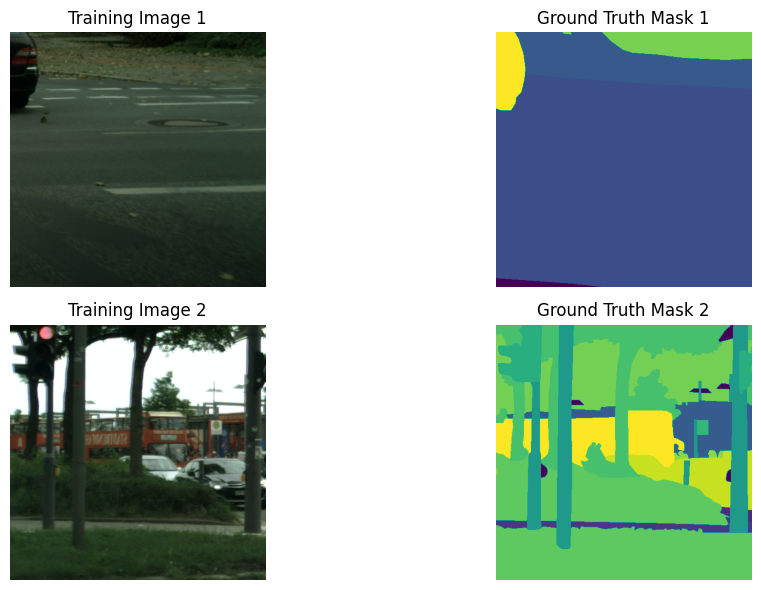

In [26]:
# Add this code after creating the dataloaders but before starting training
# (around line 208, after creating the train_loader)

def display_training_samples(dataloader, num_images=5):
    # Get a batch of training data
    dataiter = iter(dataloader)
    images, masks = next(dataiter)
    
    # Create figure with subplots
    fig, axs = plt.subplots(num_images, 2, figsize=(12, num_images * 3))
    
    for i in range(min(num_images, len(images))):
        # Process and display image
        image = images[i].numpy().transpose((1, 2, 0))
        # Denormalize image
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)
        
        # Process and display mask
        mask = masks[i].numpy()
        # print("1",mask.shape)
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        
        #Apply colormap to mask
        for class_idx, color in enumerate(COLORMAP):
            # Create a boolean mask for this class and add the color
            mask_class = (mask == class_idx)
            # Expand dimensions to match colored_mask
            mask_class_expanded = np.expand_dims(mask_class, axis=2)
            # Apply color using broadcasting
            colored_mask += mask_class_expanded * color.reshape(1, 1, 3)
            # print(colored_mask.shape)
        
        # Plot images and masks
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f"Training Image {i+1}")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(mask)
        axs[i, 1].set_title(f"Ground Truth Mask {i+1}")
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('training_samples.png')
    plt.show()

# Display 5 training samples
print("Displaying training samples...")
display_training_samples(train_loader, 2)

In [ ]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        # 1x1 convolution
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))

        # Atrous convolutions
        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        # Global average pooling
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        # Project
        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


class DecoderBlock(nn.Module):
    def __init__(self, low_level_channels, encoder_channels=256, out_channels=256):
        super(DecoderBlock, self).__init__()
        self.conv_low = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )
        self.conv_cat = nn.Sequential(
            nn.Conv2d(encoder_channels + 48, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, encoder_features, low_level_features):
        low_level_features = self.conv_low(low_level_features)
        
        # Resize encoder features to match low-level features
        encoder_features = F.interpolate(
            encoder_features, 
            size=low_level_features.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )
        
        # Concatenate
        features = torch.cat([encoder_features, low_level_features], dim=1)
        return self.conv_cat(features)


class ResNetBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetBackbone, self).__init__()
        if pretrained:
            backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        else:
            backbone = resnet50(weights=None)
        
        self.stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        
        self.layer1 = backbone.layer1  # 1/4
        self.layer2 = backbone.layer2  # 1/8
        self.layer3 = backbone.layer3  # 1/16
        self.layer4 = backbone.layer4  # 1/32
        
    def forward(self, x):
        x = self.stem(x)
        x1 = self.layer1(x)  # 1/4, stride=4
        x2 = self.layer2(x1)  # 1/8, stride=8
        x3 = self.layer3(x2)  # 1/16, stride=16
        x4 = self.layer4(x3)  # 1/32, stride=32
        
        return x1, x4


class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=34, output_stride=16, pretrained_backbone=True):
        super(DeepLabV3Plus, self).__init__()
        
        # Determine atrous rates based on output stride
        if output_stride == 16:
            atrous_rates = [6, 12, 18]
        elif output_stride == 8:
            atrous_rates = [12, 24, 36]
        else:
            raise ValueError("Output stride must be 8 or 16!")
            
        # Backbone
        self.backbone = ResNetBackbone(pretrained=pretrained_backbone)
        
        # ASPP
        self.aspp = ASPP(in_channels=2048, atrous_rates=atrous_rates)
        
        # Decoder
        self.decoder = DecoderBlock(low_level_channels=256, encoder_channels=256)
        
        # Final classifier
        self.classifier = nn.Conv2d(256, num_classes, 1)
        
    def forward(self, x):
        input_shape = x.shape[-2:]
        
        # Get backbone features
        low_level_features, encoder_features = self.backbone(x)
        
        # Apply ASPP
        aspp_features = self.aspp(encoder_features)
        
        # Decode features
        decoder_features = self.decoder(aspp_features, low_level_features)
        
        # Get output segmentation
        output = self.classifier(decoder_features)
        
        # Upsample to input resolution
        output = F.interpolate(output, size=input_shape, mode='bilinear', align_corners=False)
        
        return output, decoder_features


class ConditionInvariantDeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=34, output_stride=16, pretrained_backbone=True):
        super(ConditionInvariantDeepLabV3Plus, self).__init__()
        
        # Two separate DeepLabV3+ models with shared weights
        self.deeplab = DeepLabV3Plus(num_classes=num_classes, 
                                     output_stride=output_stride, 
                                     pretrained_backbone=pretrained_backbone)
        
    def forward(self, x_original, x_stylized):
        # Process original image
        seg_original, features_original = self.deeplab(x_original)
        
        # Process stylized image
        seg_stylized, features_stylized = self.deeplab(x_stylized)
        
        return {
            'seg_original': seg_original,
            'features_original': features_original,
            'seg_stylized': seg_stylized,
            'features_stylized': features_stylized
        }


class ConditionInvariantLoss(nn.Module):
    def __init__(self, lambda_feature=0.1):
        super(ConditionInvariantLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=255)  # 255 is typically ignored in cityscapes
        self.lambda_feature = lambda_feature
        
    def forward(self, outputs, targets):
        # Extract outputs
        seg_original = outputs['seg_original']
        features_original = outputs['features_original']
        features_stylized = outputs['features_stylized']
        
        # Segmentation loss (only applied to original image predictions)
        seg_loss = self.ce_loss(seg_original, targets)
        
        # Feature consistency loss
        feature_loss = F.mse_loss(features_original, features_stylized)
        
        # Combine losses
        total_loss = seg_loss + self.lambda_feature * feature_loss
        
        return {
            'total_loss': total_loss,
            'seg_loss': seg_loss,
            'feature_loss': feature_loss
        }


In [ ]:
model = ConditionInvariantDeepLabV3Plus(num_classes=34)
model = model.cuda() if torch.cuda.is_available() else model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionInvariantLoss(nn.Module):
    def __init__(self, lambda_feature=0.1, lambda_cosine=0.1):
        super(ConditionInvariantLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=255)
        self.lambda_feature = lambda_feature
        self.lambda_cosine = lambda_cosine

    def forward(self, outputs, targets):
        # Extract outputs
        seg_original = outputs['seg_original']
        features_original = outputs['features_original']
        features_stylized = outputs['features_stylized']
        
        # Segmentation loss
        seg_loss = self.ce_loss(seg_original, targets)

        # Feature MSE loss
        feature_loss = F.mse_loss(features_original, features_stylized)
        
        # Cosine similarity loss
        cos_sim = F.cosine_similarity(features_original, features_stylized, dim=1)
        cos_loss = torch.mean(1 - cos_sim)  # Want cosine similarity → 1, so (1 - sim)

        # Combine losses
        total_loss = seg_loss + self.lambda_feature * feature_loss + self.lambda_cosine * cos_loss

        return {
            'total_loss': total_loss,
            'seg_loss': seg_loss,
            'feature_loss': feature_loss,
            'cosine_loss': cos_loss
        }


In [ ]:
# Ignore index 0 which is 'unlabeled'
criterion = ConditionInvariantLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [29]:
 #We're using ignore_index=0 to ignore the 'unlabeled' class in our metrics
metric_iou = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, ignore_index=0).to(device)
metric_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES, ignore_index=0).to(device)

In [36]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    iou_scores = 0.0
    accuracy_scores = 0.0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)
        batch_size, _, height, width = images.shape
        if batch_size < 2 or height < 32 or width < 32:
            print(f"Warning: Small batch/image size detected: {images.shape}")
            # For single batch, use eval mode to avoid batchnorm issues
            if batch_size == 1:
                model.eval()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update metrics
        running_loss += loss.item()
        iou_scores += metric_iou(outputs.argmax(1), masks)
        accuracy_scores += metric_accuracy(outputs.argmax(1), masks)
        if batch_size == 1:
            model.train()
            model.backbone.eval() 
        
        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item()})
    
    # Compute epoch metrics
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = iou_scores / len(dataloader)
    epoch_accuracy = accuracy_scores / len(dataloader)
    
    return epoch_loss, epoch_iou, epoch_accuracy

In [52]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    iou_scores = 0.0
    accuracy_scores = 0.0
    
    progress_bar = tqdm(dataloader, desc="Validation")
    
    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            # Fix the mask shape if it has extra channel (one-hot)
            if masks.ndim == 4:
                masks = masks.argmax(dim=-1)  # shape: [B, H, W]

            batch_size, _, height, width = images.shape
            if batch_size < 2 or height < 32 or width < 32:
                print(f"Warning: Small batch/image size detected: {images.shape}")
                if batch_size == 1:
                    continue

            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            
            running_loss += loss.item()
            iou_scores += metric_iou(outputs.argmax(1), masks)
            accuracy_scores += metric_accuracy(outputs.argmax(1), masks)
            
            progress_bar.set_postfix({"val_loss": loss.item()})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = iou_scores / len(dataloader)
    epoch_accuracy = accuracy_scores / len(dataloader)
    
    return epoch_loss, epoch_iou, epoch_accuracy


In [62]:
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)['out']
            preds = outputs.argmax(1)
            
            for j in range(images.size(0)):
                if images_so_far >= num_images:
                    model.train()
                    plt.tight_layout()
                    return fig
                
                # Convert tensors to numpy arrays for visualization
                image = images[j].cpu().numpy().transpose((1, 2, 0))
                # Denormalize image
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                image = np.clip(image, 0, 1)
                
                mask = masks[j].cpu().numpy()
                pred = preds[j].cpu().numpy()

                # colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        
                # #Apply colormap to mask
                # for class_idx, color in enumerate(COLORMAP):
                #     # Create a boolean mask for this class and add the color
                #     mask_class = (mask == class_idx)
                #     # Expand dimensions to match colored_mask
                #     mask_class_expanded = np.expand_dims(mask_class, axis=2)
                #     # Apply color using broadcasting
                #     colored_mask += mask_class_expanded * color.reshape(1, 1, 3)
                colored_pred = np.zeros((pred.shape[0], pred.shape[1], 3))
                
                for class_idx, color in enumerate(COLORMAP):
                    # mask_class = mask == class_idx
                    pred_class = pred == class_idx
                    
                    for c in range(3):
                        # colored_mask[:, :, c] += mask_class * color[c]
                        colored_pred[:, :, c] += pred_class * color[c]
                
                # Plot
                axs[images_so_far, 0].imshow(image)
                axs[images_so_far, 0].set_title("Input Image")
                axs[images_so_far, 0].axis('off')
                
                axs[images_so_far, 1].imshow(mask,cmap='gray')
                axs[images_so_far, 1].set_title("Ground Truth")
                axs[images_so_far, 1].axis('off')
                
                axs[images_so_far, 2].imshow(colored_pred)
                axs[images_so_far, 2].set_title("Prediction")
                axs[images_so_far, 2].axis('off')
                
                images_so_far += 1
                
                if images_so_far >= num_images:
                    break
    
    model.train()
    plt.tight_layout()
    return fig

In [39]:
# Create a model directory
os.makedirs('models', exist_ok=True)

In [40]:
# Training loop
num_epochs = 10
best_val_loss = float('inf')
history = {
    'train_loss': [], 'train_iou': [], 'train_acc': [],
    'val_loss': [], 'val_iou': [], 'val_acc': []
}

In [41]:
print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Set model to training mode
    model.train()
        
    # Make sure backbone stays in eval mode even when model is in train mode
    model.backbone.eval()

    # Train
    train_loss, train_iou, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_iou, val_acc = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou.item())
    history['train_acc'].append(train_acc.item())
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou.item())
    history['val_acc'].append(val_acc.item())
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'models/best_model.pth')
        print("Saved best model checkpoint")

print("Training complete!")

Starting training...
Epoch 1/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c51027a20c0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c51027a20c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1550, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingD

Train Loss: 0.7556, IoU: 0.3122, Acc: 0.7992
Val Loss: 0.5270, IoU: 0.3069, Acc: 0.8518
Saved best model checkpoint
Epoch 2/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6775, IoU: 0.3199, Acc: 0.8145
Val Loss: 0.4825, IoU: 0.3160, Acc: 0.8617
Saved best model checkpoint
Epoch 3/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6421, IoU: 0.3324, Acc: 0.8203
Val Loss: 0.4589, IoU: 0.3159, Acc: 0.8631
Saved best model checkpoint
Epoch 4/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6170, IoU: 0.3288, Acc: 0.8257
Val Loss: 0.4603, IoU: 0.3194, Acc: 0.8633
Epoch 5/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5967, IoU: 0.3326, Acc: 0.8300
Val Loss: 0.4720, IoU: 0.3149, Acc: 0.8585
Epoch 6/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5649, IoU: 0.3350, Acc: 0.8375
Val Loss: 0.4427, IoU: 0.3236, Acc: 0.8670
Saved best model checkpoint
Epoch 7/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c51027a20c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7c51027a20c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
      if w.is_alive():   
  ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^^ ^ 
    File "/usr/lib/

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5625, IoU: 0.3397, Acc: 0.8377
Val Loss: 0.4403, IoU: 0.3262, Acc: 0.8672
Saved best model checkpoint
Epoch 8/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5475, IoU: 0.3437, Acc: 0.8410
Val Loss: 0.4420, IoU: 0.3327, Acc: 0.8649
Epoch 9/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5527, IoU: 0.3375, Acc: 0.8398
Val Loss: 0.4413, IoU: 0.3246, Acc: 0.8671
Epoch 10/10


Training:   0%|          | 0/1488 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5295, IoU: 0.3457, Acc: 0.8467
Val Loss: 0.4207, IoU: 0.3377, Acc: 0.8720
Saved best model checkpoint
Training complete!


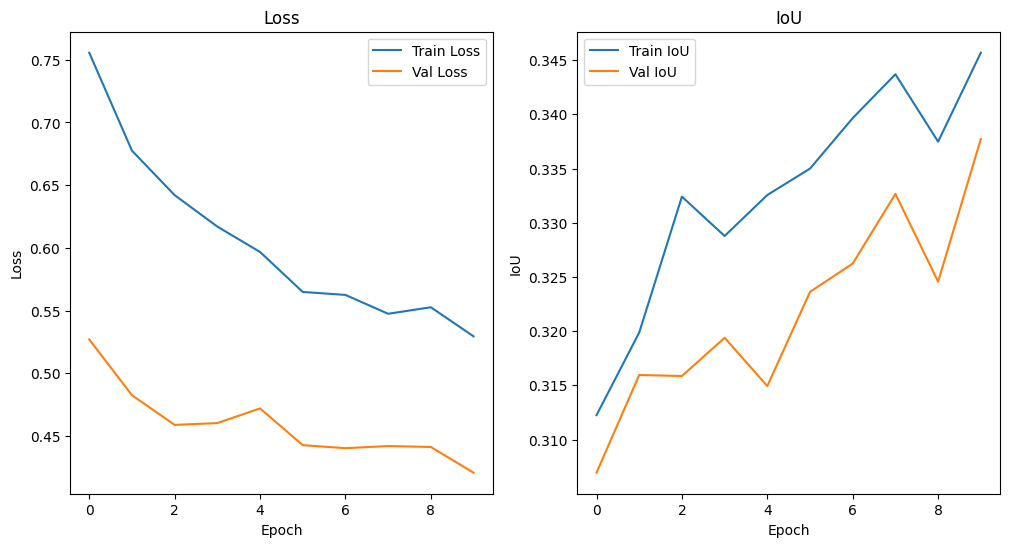

In [47]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_iou'], label='Train IoU')
plt.plot(history['val_iou'], label='Val IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

In [48]:
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [49]:
# Load best model for evaluation
model.load_state_dict(torch.load('models/best_model.pth'))

/tmp/ipykernel_31/2252297861.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model.pth'))


<All keys matched successfully>

In [53]:
test_loss, test_iou, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, Acc: {test_acc:.4f}")

Validation:   0%|          | 0/763 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c51027a20c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c51027a20c0>^^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^    ^if w.is_alive():

    File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
    ^  ^ ^^ ^ ^^ ^ ^ ^^^^^^
^  File "

Test Loss: nan, IoU: nan, Acc: 0.0000


Generating predictions visualization...


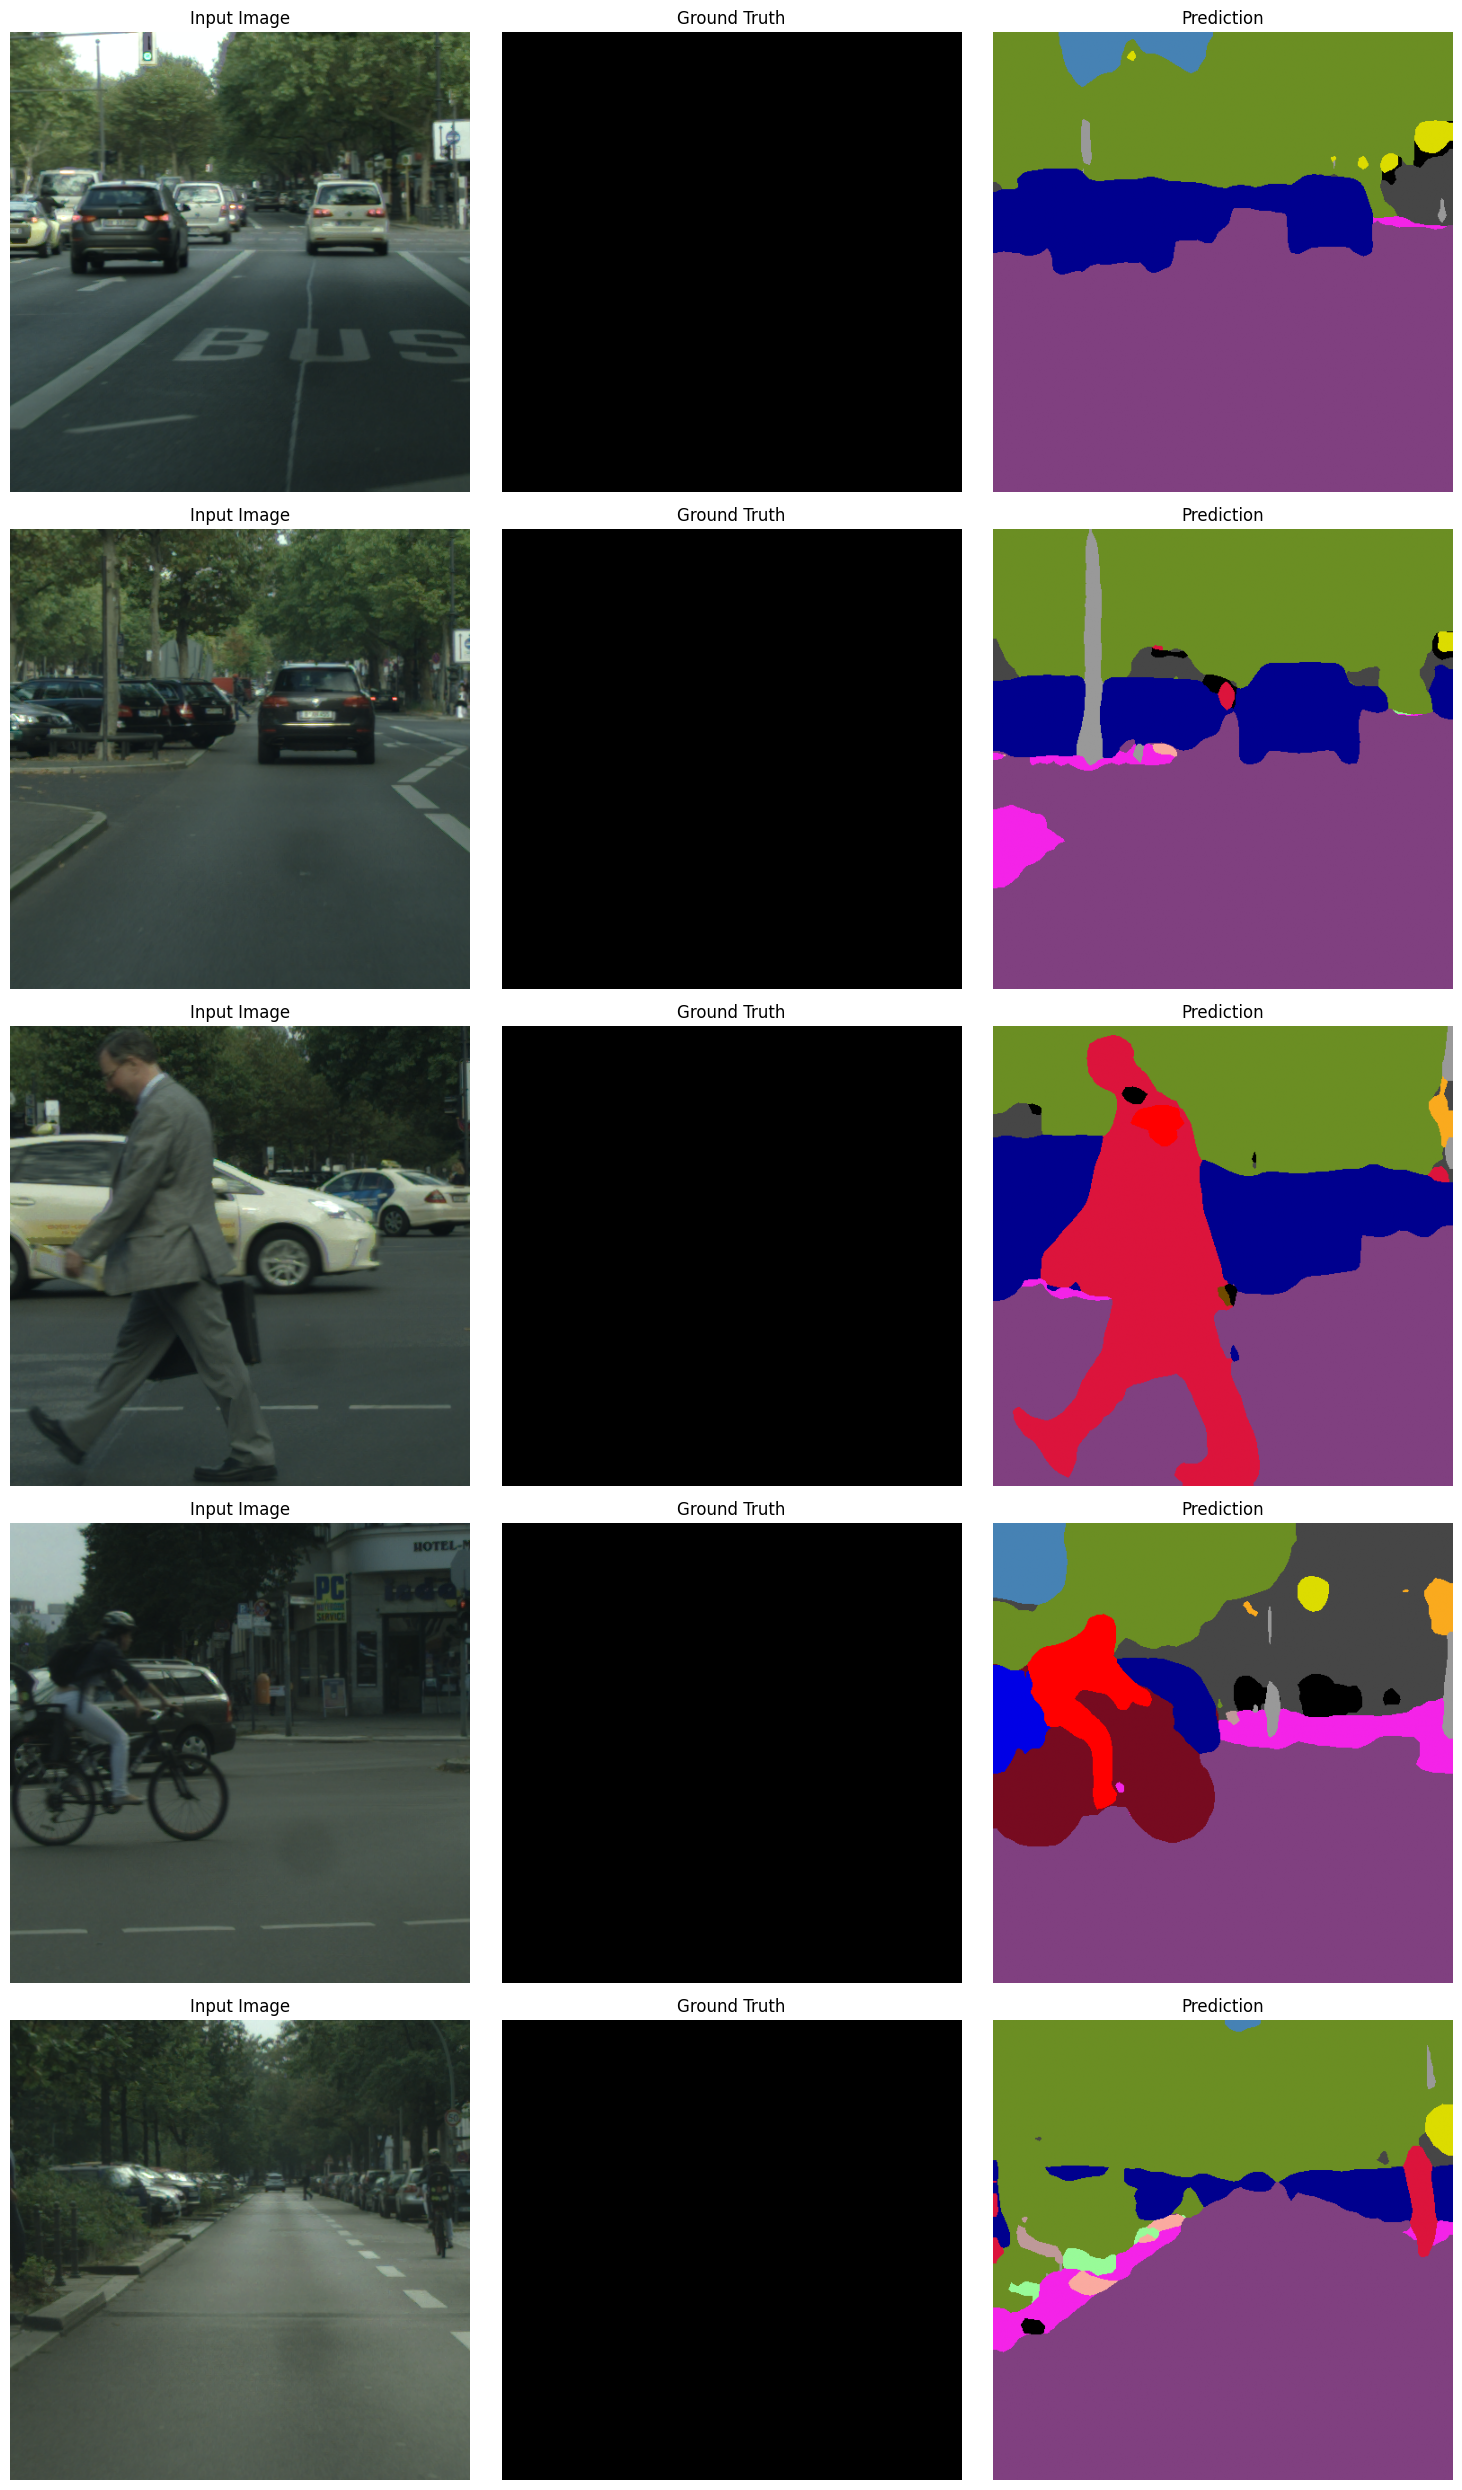

In [63]:
# Visualize some predictions
print("Generating predictions visualization...")
fig = visualize_predictions(model, test_loader, device)
plt.savefig('predictions.png')
plt.show()

In [66]:
def evaluate_class_iou(model, dataloader, device):
    model.eval()
    class_intersection = torch.zeros(NUM_CLASSES).to(device)
    class_union = torch.zeros(NUM_CLASSES).to(device)
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Class IoU Evaluation"):
            images = images.to(device)
            masks = masks.to(device)
            batch_size, _, height, width = images.shape
            if batch_size < 2 or height < 32 or width < 32:
                print(f"Warning: Small batch/image size detected: {images.shape}")
                if batch_size == 1:
                    continue
            
            outputs = model(images)['out']
            preds = outputs.argmax(1)
            
            # Skip class 0 (unlabeled) and evaluate rest
            for cls in range(1, NUM_CLASSES):  # Start from 1 to skip unlabeled
                pred_cls = preds == cls
                target_cls = masks == cls
                intersection = (pred_cls & target_cls).sum().float()
                union = (pred_cls | target_cls).sum().float()
                class_intersection[cls] += intersection
                class_union[cls] += union
    
    # Calculate IoU - add small epsilon to avoid division by zero
    class_iou = class_intersection / (class_union + 1e-8)
    
    # Set IoU for unlabeled class to 0 as we're ignoring it
    class_iou[0] = 0.0
    
    return class_iou.cpu().numpy()

In [67]:
# Evaluate class-wise IoU
class_ious = evaluate_class_iou(model, test_loader, device)

Class IoU Evaluation:   0%|          | 0/763 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c51027a20c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c51027a20c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

RuntimeError: The size of tensor a (512) must match the size of tensor b (4) at non-singleton dimension 3

In [ ]:
# Print class-wise IoU (skip unlabeled class)
print("\nClass-wise IoU:")
for cls in range(1, NUM_CLASSES):  # Skip class 0 (unlabeled)
    print(f"{CITYSCAPES_CLASSES[cls]}: {class_ious[cls]:.4f}")

In [ ]:
# Create a bar plot for class-wise IoU (skip unlabeled class)
plt.figure(figsize=(20, 8))
classes_to_plot = {k: v for k, v in CITYSCAPES_CLASSES.items() if k > 0}  # Skip unlabeled
values_to_plot = class_ious[1:]  # Skip first element (unlabeled)
plt.bar(classes_to_plot.values(), values_to_plot)
plt.xlabel('Class')
plt.ylabel('IoU')
plt.title('Class-wise IoU (Excluding Unlabeled Class)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('class_iou.png')
plt.show()


In [ ]:
# Create a bar plot for class-wise IoU (skip unlabeled class)
plt.figure(figsize=(20, 8))
classes_to_plot = {k: v for k, v in CITYSCAPES_CLASSES.items() if k > 0}  # Skip unlabeled
values_to_plot = class_ious[1:]  # Skip first element (unlabeled)
plt.bar(classes_to_plot.values(), values_to_plot)
plt.xlabel('Class')
plt.ylabel('IoU')
plt.title('Class-wise IoU (Excluding Unlabeled Class)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('class_iou.png')
plt.show()


In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F

def load_and_predict_image(model, image_path, colormap, device, crop_size=512):
    model.eval()
    
    # Load and convert image to RGB
    image = Image.open(image_path).convert('RGB')
    w, h = image.size

    # Resize if smaller than crop size
    if h < crop_size or w < crop_size:
        ratio = max(crop_size / h, crop_size / w)
        new_h, new_w = int(h * ratio), int(w * ratio)
        image = image.resize((new_w, new_h), Image.BILINEAR)
        h, w = new_h, new_w

    # Center crop
    image_cropped = F.center_crop(image, (crop_size, crop_size))

    # Normalize image
    image_tensor = F.to_tensor(image_cropped)
    image_tensor = F.normalize(image_tensor, mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)['out']
        pred = output.argmax(1).squeeze().cpu().numpy()

    # Convert input image to displayable numpy array
    display_image = np.array(image_cropped).astype(np.float32) / 255.0

    # Create color prediction
    colored_pred = np.zeros((pred.shape[0], pred.shape[1], 3))
    for class_idx, color in enumerate(colormap):
        mask = (pred == class_idx)
        for c in range(3):
            colored_pred[:, :, c] += mask * color[c]
    
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(display_image)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(pred.astype(np.uint8))
    axs[1].set_title("Predicted Segmentation")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


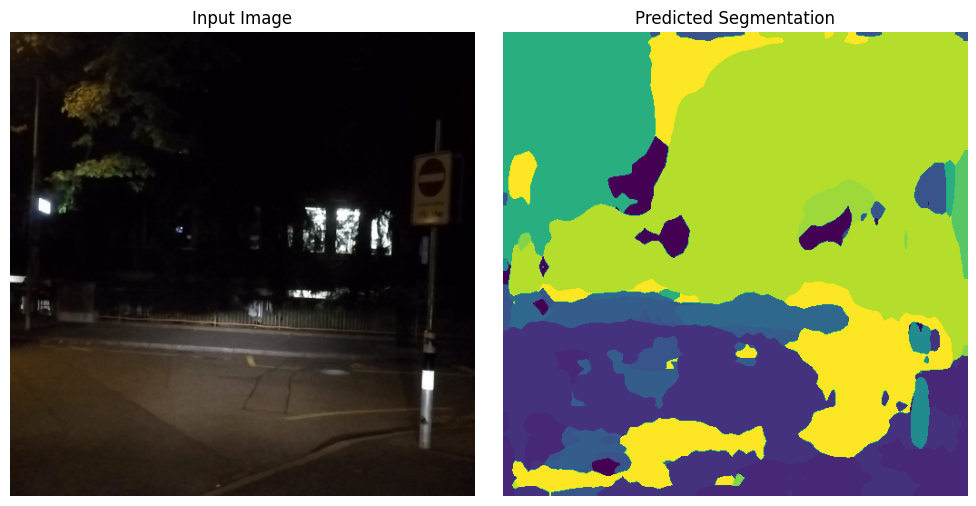

In [72]:
image_path = "/kaggle/input/zurich-dataset/WhatsApp Image 2025-05-05 at 14./WhatsApp Image 2025-05-05 at 14.07.58.jpeg"
load_and_predict_image(model, image_path, COLORMAP, device)

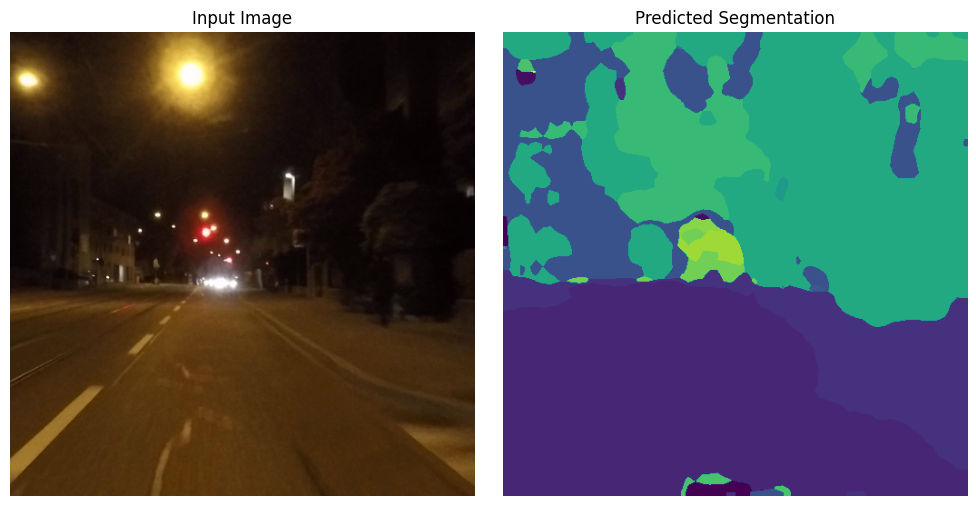

In [73]:
image_path = "/kaggle/input/zurich-dataset/WhatsApp Image 2025-05-05 at 14./WhatsApp Image 2025-05-05 at 14.08.56.jpeg"
load_and_predict_image(model, image_path, COLORMAP, device)

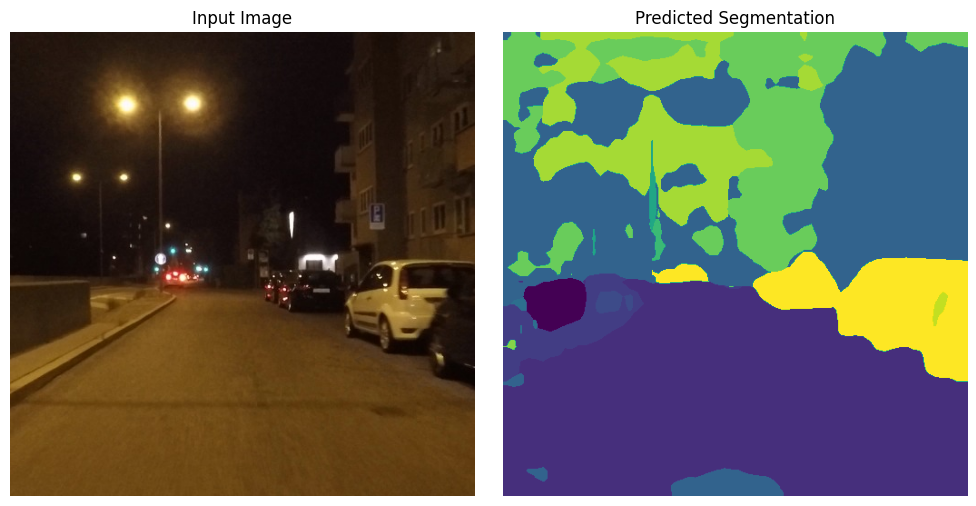

In [74]:
image_path = "/kaggle/input/zurich-dataset/WhatsApp Image 2025-05-05 at 14./WhatsApp Image 2025-05-05 at 14.09.52.jpeg"
load_and_predict_image(model, image_path, COLORMAP, device)